## 1. Land filter
## 2. Valid waveform filter
## 3. Ransac filter and ransac prediction (based on land filter,waveform filter,and both, respectively)

In [1]:
import sys
sys.path.append("../utils")
import xarray as xr
import numpy as np
import os
from tiff_io import readTiff
from osgeo import gdal
import matplotlib.pyplot as plt
from get_filesPath import get_filesPath
from ransac_filter import ransac_filter


In [2]:
root_dir = os.path.dirname(os.getcwd())
dir_s3l2 = root_dir+'/test_data/s3a-relative-orbit-260&309'
path_rsimg = root_dir+'/test_data/rs_image/greatbay_l8_img.tif'


In [3]:
## get files path
files_path = get_filesPath(base=dir_s3l2, key_words='enhanced_measurement_subs_preproc_mainproc.nc')
files_path = sorted(files_path)
print('s3l2 files number:', len(files_path))


s3l2 files number: 50


In [4]:
retracker = ['ocean', 'ocog', 'ice_sheet', 'sea_ice']
for path_s3l2 in files_path:
    print(path_s3l2)
    s3_l2 = xr.open_dataset(path_s3l2)
    for retrack in retracker:

        ### 1. land filter
        ssha_land_filter = np.copy(s3_l2['ssha_estimate_'+retrack])
        ssha_land_filter[s3_l2['surf_type_20_ku'] != 0.0] = np.nan
        # ssha_land_filter[s3_l2['fp_wat_per'] != 1] = np.nan
        # add land filtered ssha variable
        s3_l2['ssha_land_filter_'+retrack] = (['time_20_ku'], ssha_land_filter)
        s3_l2['ssha_land_filter_'+retrack].attrs['name'] = 'land filtered ssha based on the retracker ssha of ' + retrack + ' method'
       
        ### 2. valid waveform filter
        ## based original ssha
        ssha_wf_filter = np.copy(s3_l2['ssha_estimate_'+retrack])
        ssha_wf_filter[s3_l2['wf_cls'] != 1] = np.nan
        ## based on land filtered ssha
        ssha_land_wf_filter = np.copy(ssha_land_filter)
        ssha_land_wf_filter[s3_l2['wf_cls'] != 1] = np.nan
        # add valid waveform filtered ssha variable
        s3_l2['ssha_wf_filter_'+retrack] = (['time_20_ku'], ssha_wf_filter)
        s3_l2['ssha_wf_filter_'+retrack].attrs['name'] = 'valid waveform filtered ssha based on the retracker ssha of ' + retrack + ' method'
        s3_l2['ssha_land_wf_filter_'+retrack] = (['time_20_ku'], ssha_land_wf_filter)
        s3_l2['ssha_land_wf_filter_'+retrack].attrs['name'] = 'both land and valid waveform filtered ssha based on the retracker ssha of ' + retrack + ' method'
        
        ### 3. ransac filter: land+ransac; wf+ransac; land+wf+ransac
        y_land_ransac_filter, y_land_ransac_pred = ransac_filter(x=s3_l2['lon_20_ku'], y=ssha_land_filter, thre=0.2)
        y_wf_ransac_filter, y_wf_ransac_pred = ransac_filter(x=s3_l2['lon_20_ku'], y=ssha_wf_filter, thre=0.2)
        y_land_wf_ransac_filter, y_land_wf_ransac_pred = ransac_filter(x=s3_l2['lon_20_ku'], y=ssha_land_wf_filter, thre=0.2)
        ## add ransac filtered ssha variable to .nc file
        ## land+ransac filter
        s3_l2['ssha_land_ransac_filter_'+retrack] = (['time_20_ku'], y_land_ransac_filter)
        s3_l2['ssha_land_ransac_filter_'+retrack].attrs['name'] = 'land and ransac filtered ssha based on the retracker ssha of ' + retrack + ' method'
        ## waveform+ransac filter
        s3_l2['ssha_wf_ransac_filter_'+retrack] = (['time_20_ku'], y_wf_ransac_filter)
        s3_l2['ssha_wf_ransac_filter_'+retrack].attrs['name'] = 'wf and ransac filtered ssha based on the retracker ssha of ' + retrack + ' method'
        ## land+waveform+ransac filter
        s3_l2['ssha_land_wf_ransac_filter_'+retrack] = (['time_20_ku'], y_land_wf_ransac_filter)
        s3_l2['ssha_land_wf_ransac_filter_'+retrack].attrs['name'] = 'land, wf and ransac filtered ssha based on the retracker ssha of ' + retrack + ' method'
        # add ransac prediction variable
        ## land+ransac prediction
        s3_l2['ssha_land_ransac_pred_'+retrack] = (['time_20_ku'], y_land_ransac_pred)
        s3_l2['ssha_land_ransac_pred_'+retrack].attrs['name'] = 'ransac prediction (based on land filter) of ssha based on the retracker ssha of ' + retrack + ' method'
        ## waveform+ransac prediction
        s3_l2['ssha_wf_ransac_pred_'+retrack] = (['time_20_ku'], y_wf_ransac_pred)
        s3_l2['ssha_wf_ransac_pred_'+retrack].attrs['name'] = 'ransac prediction (based on land filter) of ssha based on the retracker ssha of ' + retrack + ' method'
        ## land+waveform+ransac prediction
        s3_l2['ssha_land_wf_ransac_pred_'+retrack] = (['time_20_ku'], y_land_wf_ransac_pred)
        s3_l2['ssha_land_wf_ransac_pred_'+retrack].attrs['name'] = 'ransac prediction (based on land and wf filter) of ssha based on the retracker ssha of ' + retrack + ' method'

    ## writh to new .nc file
    dir_file = os.path.split(path_s3l2)[0]
    name_file = os.path.split(path_s3l2)[1].split('.')[0]
    path_s3l2_new = os.path.join(dir_file, name_file+'_postproc.nc')
    s3_l2.to_netcdf(path=path_s3l2_new)

 saving variable lon_20_c with floating point data as an integer dtype without any _FillValue to use for NaNs
/Users/luo/OneDrive/SWOT/Code-algorithms/radar-altimetry-toolbox/test_data/s3a-relative-orbit-260&309/S3A_SR_2_WAT____20200524T134003_20200524T142755_20200619T060829_2872_058_309______MAR_O_NT_004.SEN3/enhanced_measurement_subs_preproc_mainproc.nc
ipykernel_launcher:57: SerializationWarning: saving variable lat_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:57: SerializationWarning: saving variable lon_01 with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:57: SerializationWarning: saving variable lat_20_ku with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:57: SerializationWarning: saving variable lon_20_ku with floating point data as an integer dtype without any _FillValue to use for NaNs
ipykernel_launcher:57: Seria

## Visualize the processing result.

(114.400751, 114.13436399999999, -0.2, 1.0)

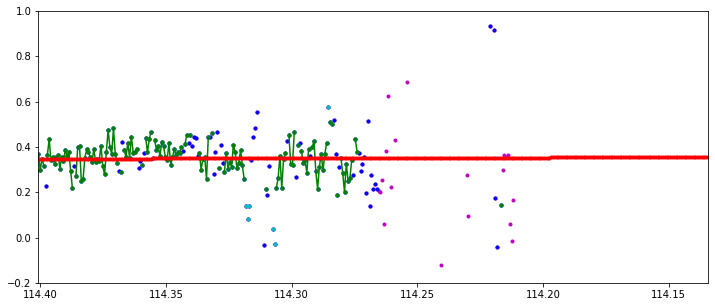

In [5]:
retracker = 'ocean'
fig = plt.figure(figsize=(12, 5))
plt.plot(s3_l2['lon_20_ku'], s3_l2['ssha_estimate_'+retracker], 'm.')
plt.plot(s3_l2['lon_20_ku'], s3_l2['ssha_land_filter_'+retracker], 'b.')
plt.plot(s3_l2['lon_20_ku'], s3_l2['ssha_wf_filter_'+retracker], 'c.')
plt.plot(s3_l2['lon_20_ku'], s3_l2['ssha_land_wf_ransac_filter_'+retracker], 'g.-')
plt.plot(s3_l2['lon_20_ku'], s3_l2['ssha_land_ransac_pred_'+retracker], 'r.')
plt.axis([s3_l2['lon_20_ku'][0], s3_l2['lon_20_ku'][-1], -0.2, 1])

